In [2]:
import os
import tarfile
from six.moves import urllib
#Esto es para hacer fetch constantemente con la base de datos
DOWNLOAD_ROOT="https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH=os.path.join("datasets", "housing")
HOUSING_URL=DOWNLOAD_ROOT +"datasets/housing/housing.tgz"
def  fetch_housing_data(housing_url=HOUSING_URL,  housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path  =  os.path.join(housing_path,  "housing.tgz")  
    urllib.request.urlretrieve(housing_url,  tgz_path) 
    housing_tgz  =  tarfile.open(tgz_path) 
    housing_tgz.extractall(path=housing_path) 
    housing_tgz.close()
            
fetch_housing_data()

In [3]:
import pandas as pd
#Creamos el archivo pandas
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path=os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)


In [4]:
housing=load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


In [6]:
housing["ocean_proximity"].value_counts()



<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


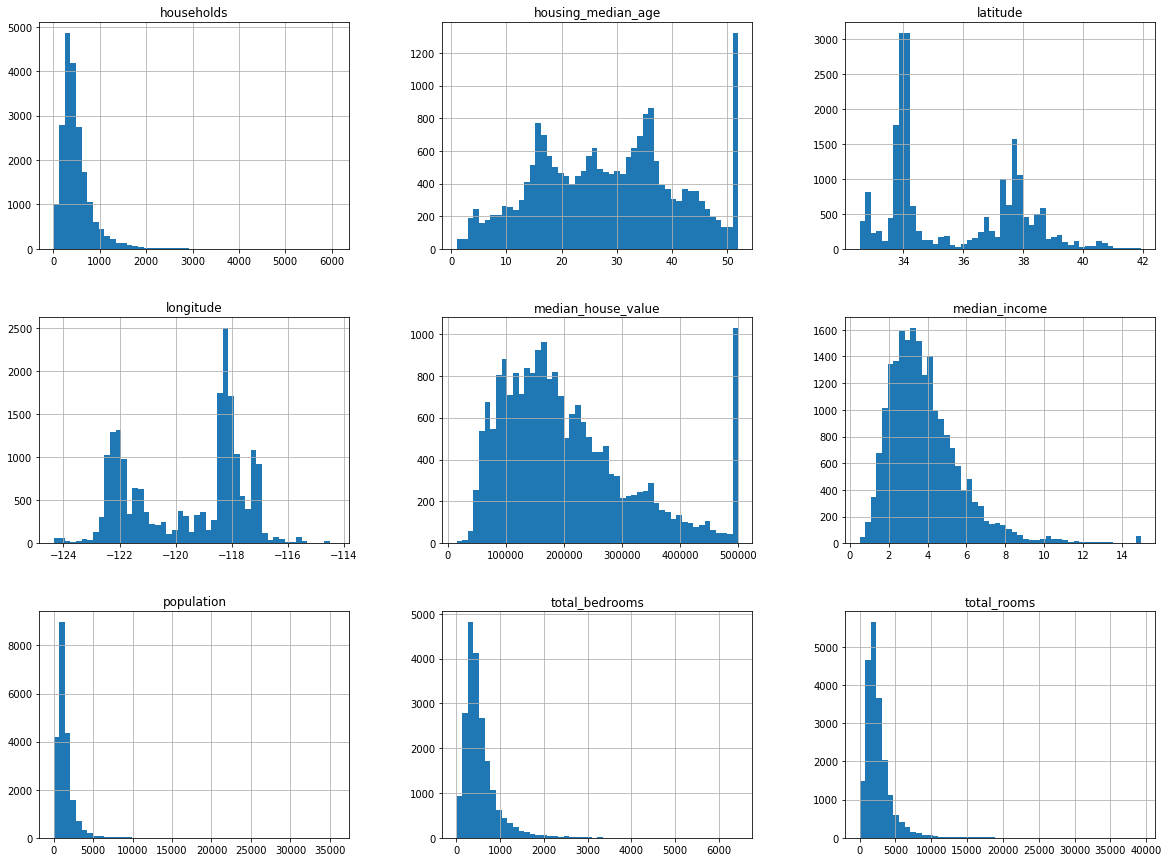

In [8]:
%matplotlib inline 
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [9]:
import numpy as np
def split_train_test(data,test_ratio):
    indices_barajeados=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_indices=indices_barajeados[:test_set_size]
    train_indices=indices_barajeados[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
train_set, test_set= split_train_test(housing,0.2)
len(train_set)
    

16512

In [10]:
len(test_set)

4128

In [11]:
#### voy a añadir una id con hash 
from zlib import crc32 
def test_set_check(identifier,test_ratio):##esto verifica ... o al menos eso creo 
    return crc32(np.int64(identifier))& 0Xffffffff < test_ratio * 2**32

def split_train_test_by_id(data,test_ratio,id_column):
    ids=data[id_column]
    in_test_set=ids.apply(lambda id_: test_set_check(id_,test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]
housing_with_id=housing.reset_index()#añade la columna index
train_test, test_set=split_train_test_by_id(housing_with_id,0.2,"index")
    
# pero si usas el index como un identificador unico entonces debes asegurar que la nueva data se añada al final
# del dataset y ninguna fila sera borrada nunca para evitar eso usaremos una mezcla entrre la logitud y latitud 
# que nos brinda mas estabilidad 
housing_with_id["id"]=housing["longitude"]*1000+housing["latitude"]
train_test, test_set=split_train_test_by_id(housing_with_id,0.2,"id")




In [12]:
### Scikit-Learn tiene varias funciones para dividir datasets en multiple subsets de varias formas
### una de ellas es split_train_test que hace algo muy parecida a la que fue definida arriba pero con par de cosas mas
### el primero es el random_state que te permite crear una semilla, lo segundo es que te permite pasar multiples
### datasets con un identico numero de filas dividirlas con los mismos indices 

from sklearn.model_selection import train_test_split
train_set, test_set= train_test_split(housing,test_size=0.2,random_state=42)




0        5
1        5
2        5
3        4
4        3
        ..
20635    2
20636    2
20637    2
20638    2
20639    2
Name: income_cat, Length: 20640, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]


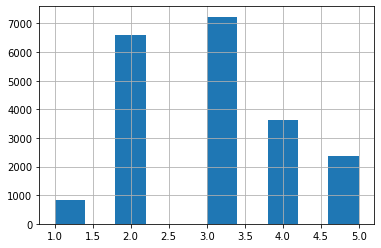

In [13]:
##divido la media de ingresos por categoria 
housing["income_cat"]=pd.cut(housing["median_income"],
                             bins=[0.,1.5,3.0,4.5,6.0,np.inf],
                             labels=[1,2,3,4,5]
                            )
housing["income_cat"].hist()
print(housing["income_cat"])

In [14]:
### Para obtener una fiel representacion de los stratos de ingreso medio que tenemos dividirlos segun su categoria y 
### Y luego llevar esa represetancion a nuestros dataset
from sklearn.model_selection import StratifiedShuffleSplit
split=StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42)
for train_index, test_index in split.split(housing,housing["income_cat"]):
    strat_train_set=housing.loc[train_index]
    strat_test_set=housing.loc[test_index]
    
print(strat_test_set["income_cat"].value_counts()/len(strat_test_set))  
print(strat_train_set["income_cat"].value_counts()/len(strat_train_set))


3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64
3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64


In [15]:
### Una vez finalizada esta estratificacion procedemos a eliminar el valor "income cat"
for set_ in (strat_test_set,strat_train_set):
    set_.drop("income_cat",axis=1,inplace=True)


In [16]:
#Estamos creando una copia para poder manipularla sin miedo ()
housing=strat_train_set.copy()

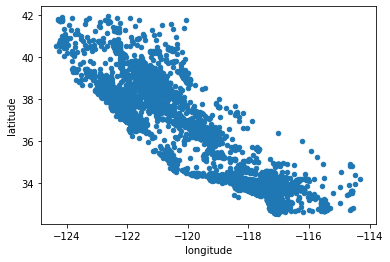

In [17]:
housing.plot(kind="scatter",x="longitude",y="latitude")

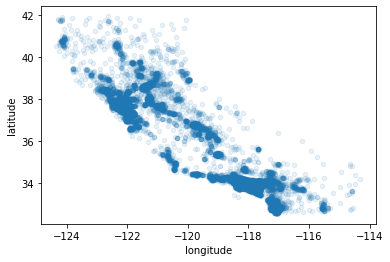

In [18]:
housing.plot(kind="scatter",x="longitude",y="latitude", alpha=0.1)

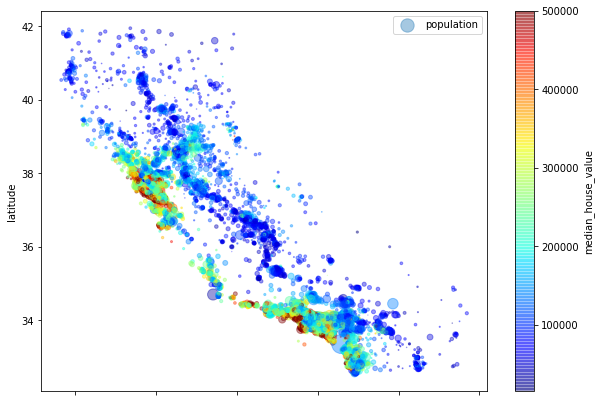

In [23]:
housing.plot(kind="scatter",x="longitude",y="latitude", alpha=0.4,s=housing["population"]/100,label="population"
             ,figsize=(10,7),c="median_house_value",cmap=plt.get_cmap("jet"),colorbar=True,)
#ptl.legend()

In [20]:
'''
Los coeficientes de correlacion tienen un rango de -1 a 1. Cuando esta cerca de 1, significa que hay una correlacion 
fuertemente positiva; por ejemplo, la media del valor de las casa tiende a subir cuando media de ingreso aunmenta.
Cuando el coeficiente esta cerca de -1, significa que correlacion fuertemente negativa, se puede observar la pequeña 
correlacion negativa entre la latitud  y el valor medio de las casas. Finalmente los coeficientes cercanos a 0 significan 
que no hay correlacion lineal 

'''

'\nLos coeficientes de correlacion tienen un rango de -1 a 1. Cuando esta cerca de 1, significa que hay una correlacion \nfuertemente positiva; por ejemplo, la media del valor de las casa tiende a subir cuando media de ingreso aunmenta.\nCuando el coeficiente esta cerca de -1, significa que correlacion fuertemente negativa, se puede observar que mientras\nmas \n\n'

In [27]:
corr_matrix=housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0xa402eacc>,
      dtype=object)

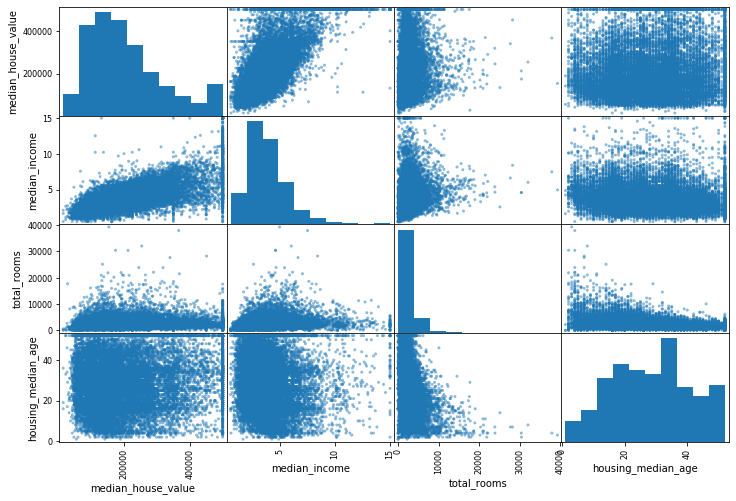

In [28]:
'''
Los coeficientes de correlacion solo miden las correlaciones lineales (si x sube entonces y generalmente sube/baja)
Otra forma de checkear la correlacion entre los atributos es usando la funcion scatter_matrix, que compara cada
atributo con otro atributo (ambos deben ser numericos)
'''
from pandas.plotting import scatter_matrix
attributes=["median_house_value","median_income","total_rooms","housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12,8))

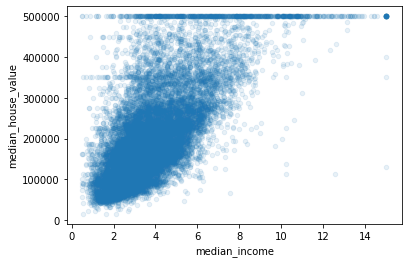

In [30]:
'''
El atributo mas prometedor para predecir el valor medio de una casa es el ingrso medio 
'''
housing.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.1)

In [ ]:
'''
Esta grafica revela un par de cosas interesante. 
Primero que la correlacion es muy fuerte observando que los puntos no son muy dispersos
Segundo el precio se tapa en los 500k pero tambien revela la existencia de una linea horizontal alrededor de los 45k
los 350k y tambien en los 280k
'''